In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymc
import numpy as np
import pandas as pd
from DB import DB
import util
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
unstacked, stacked, teams = util.get_data(2013)

In [4]:
unstacked.shape, stacked.shape, teams.shape, 2*unstacked.shape[0]

((5378, 13), (10756, 16), (350, 2), 10756)

In [5]:
stacked.head()

,dt,hteam_id,ateam_id,home_score,away_score,neutral,neutral_site,home_outcome,numot,game_id,opp_string,team,pts,poss,team_id,iteam
0,2013-04-04,51,312,74,54,True,"Madison Square Garden, New York,NY",True,0,2019716,Iowa,Iowa,54,68.550,312,122
1,2013-04-02,312,392,71,60,True,"Madison Square Garden, New York, NY",True,0,1999211,Maryland,Iowa,71,63.400,312,122
2,2013-03-27,746,312,64,75,False,None,False,0,1981123,Iowa,Iowa,75,65.125,312,122
3,2013-03-22,312,683,75,63,False,None,True,0,1948633,Iowa,Iowa,75,62.975,312,122
4,2013-03-20,312,305,68,52,False,None,True,0,1942259,Iowa,Iowa,68,65.350,312,122


In [6]:
pace_initial = stacked.groupby('iteam').mean()['poss'].values
teams['pace_initial'] = pace_initial

In [7]:
num_teams = teams.shape[0]
home_team_idx = unstacked.i_hteam.values
away_team_idx = unstacked.i_ateam.values
observed_pace = unstacked.poss.values
tau = pymc.Uniform('tau', (1. / 20**2), (1. / 3**2))  # equivalent to stddev between 1 and inf
pace_prior = pymc.Normal("pace_prior", mu=0, tau=tau, size=num_teams, value=pace_initial)
pace_intercept = pymc.Normal('intercept', 4, 1 / (1)**2, value=4)

@pymc.deterministic
def pace_rtg(pace=pace_prior):
    p = pace.copy()
    p = p - np.mean(pace)
    return p
        
@pymc.deterministic
def mu_pace(home_team=home_team_idx,
               away_team=away_team_idx,
               paces=pace_rtg,
               pace_intercept=pace_intercept):
    return pace_intercept + paces[home_team] + paces[away_team]

tau_poss = pymc.Uniform('tau_poss', (1 / 20)**0.5,(1 / 1)**0.5)
poss = pymc.Normal('poss', mu=mu_pace, tau=tau_poss, value=observed_pace, observed=True)
# poss = pymc.Poisson('poss', mu=mu_pace, value=observed_pace, observed=True)
poss_pred = pymc.Normal('poss_pred', mu=mu_pace, tau=tau_poss)


In [8]:
model = pymc.Model([mu_pace, pace_prior, tau, pace_rtg, poss, pace_intercept, tau_poss, poss_pred])
mcmc = pymc.MCMC(model)
mcmc.sample(10000, 3000)

 [-----------------100%-----------------] 10000 of 10000 complete in 10.7 sec

In [9]:
teams['mean_pace_rtg'] = pace_rtg.stats()['mean']

In [10]:
kenpom = pd.read_sql("SELECT adjt, team FROM kenpom_ranks WHERE year=2013", DB.conn)
kenpom = kenpom.merge(all_teams, left_on="team", right_on="kenpom")
all_teams = pd.read_sql("SELECT kenpom, ncaaid FROM teams", DB.conn)
df = teams.merge(kenpom, left_on='team_id', right_on='ncaaid')
df.drop('kenpom', axis=1)
# kenpom.head()
teams.shape

NameError: name 'all_teams' is not defined

In [11]:
merged = teams.merge(kenpom, how='left', left_on='team_id', right_on='ncaaid')
merged[pd.isnull(merged.ncaaid)]
# note: it is hard to get the teams we rate and the kenpom teams to line up exactly,
# but we want to compare the rankings (since our scale is not the same as kenpom's scale)
# to each other. but how to compare uneven length rankings? We can just inject random place
# holders into the lacking ranking and it will be about the same

KeyError: 'ncaaid'

Plotting intercept


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


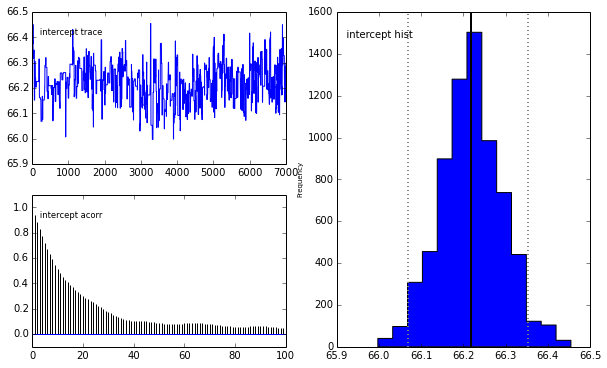

In [12]:
pymc.Matplot.plot(pace_intercept)

(array([ 0.00128536,  0.01327046,  0.04616869,  0.06461532,  0.04012403,
         0.01594539,  0.00396029,  0.00100744,  0.00031265,  0.00013896]),
 array([  47.3625,   52.715 ,   58.0675,   63.42  ,   68.7725,   74.125 ,
          79.4775,   84.83  ,   90.1825,   95.535 ,  100.8875]),
 <a list of 10 Patch objects>)

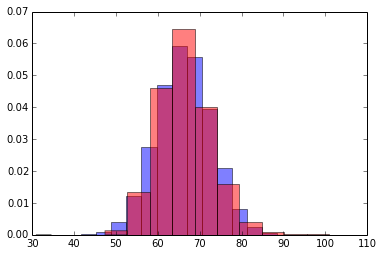

In [13]:
plt.hist(poss_pred.trace().ravel(), normed=True, alpha=0.5, bins=20)
# plt.hist(observed_pace)
plt.hist(observed_pace[~pd.isnull(observed_pace)], color='r', normed=True, alpha=0.5)

In [14]:
bteams = pd.read_sql("SELECT * FROM teams WHERE conf='B10'", DB.conn)
b10_teams = set(bteams.ncaaid.values)

In [15]:
pace_intercept.stats()
teams['pace'] = pace_rtg.stats()['mean']
teams['pace2'] = teams.pace + pace_intercept.stats()['mean']
teams['pace_initial_rank'] = teams.pace_initial.rank(ascending=False) + 4
teams['pace_rank'] = teams.pace.rank(ascending=False) + 4
teams[teams.team_id.isin(b10_teams)].sort('pace', ascending=False)

teams.sort('pace', ascending=False).head(50)

,team_id,iteam,pace_initial,mean_pace_rtg,pace,pace2,pace_initial_rank,pace_rank
330,1004,330,74.895536,7.649213,7.649213,73.868030,5,5
203,508,203,73.402679,7.045180,7.045180,73.263997,7,6
69,176,69,72.454688,6.455161,6.455161,72.673978,8,7
5,9,5,71.279687,6.061854,6.061854,72.280671,23,8
120,310,120,72.331618,6.033584,6.033584,72.252401,9,9
186,474,186,73.870455,6.024004,6.024004,72.242821,6,10
347,28600,347,71.869828,6.021638,6.021638,72.240455,13,11
306,741,306,72.236111,5.911646,5.911646,72.130463,10,12
270,670,270,71.715152,5.684722,5.684722,71.903539,17,13
179,464,179,71.481034,5.511268,5.511268,71.730085,19,14


In [25]:
games.head()

,game_id,dt,hteam,team_id_x,ateam,team_id_y,hpts,hposs,apts,aposs,i_hteam,i_ateam,poss
0,1999211,2013-04-02,Iowa,312,Maryland,392,71,63.400,60,64.600,1,83,64.0000
1,1948633,2013-03-22,Iowa,312,Stony Brook,683,75,62.975,63,63.075,1,234,63.0250
2,1942259,2013-03-20,Iowa,312,Indiana St.,305,68,65.350,52,65.225,1,54,65.2875
3,1871394,2013-03-09,Iowa,312,Nebraska,463,74,56.125,60,56.225,1,6,56.1750
4,1835252,2013-03-05,Iowa,312,Illinois,301,63,67.500,55,68.075,1,34,67.7875


In [118]:
games['pred'] = np.mean(poss_pred.trace(), axis=0)
trace = poss_pred.trace()
trace.shape

(7000, 5267)

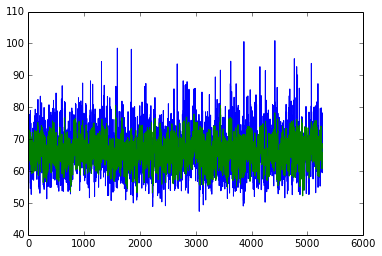

In [30]:
plt.plot(range(games.shape[0]), games.poss)
plt.plot(range(games.shape[0]), games.pred)

In [31]:
from sklearn.metrics import r2_score

In [32]:
r2_score(games.poss, games.pred)

0.38777394311599989

(array([   16.,    93.,   413.,  1195.,  1830.,  1760.,  1178.,   406.,
           94.,    15.]),
 array([ 65.7970665 ,  65.86804546,  65.93902442,  66.01000337,
         66.08098233,  66.15196129,  66.22294025,  66.29391921,
         66.36489817,  66.43587713,  66.50685609]),
 <a list of 10 Patch objects>)

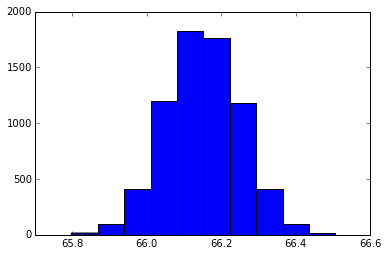

In [36]:
season_average = np.mean(poss_pred.trace(), axis=1)
plt.hist(season_average)

(array([   7.,   30.,  125.,  250.,  515.,  794.,  948.,  862.,  685.,
         451.,  297.,  150.,   82.,   29.,   23.,    6.,    4.,    5.,
           1.,    3.]),
 array([  47.3625 ,   50.03875,   52.715  ,   55.39125,   58.0675 ,
          60.74375,   63.42   ,   66.09625,   68.7725 ,   71.44875,
          74.125  ,   76.80125,   79.4775 ,   82.15375,   84.83   ,
          87.50625,   90.1825 ,   92.85875,   95.535  ,   98.21125,
         100.8875 ]),
 <a list of 20 Patch objects>)

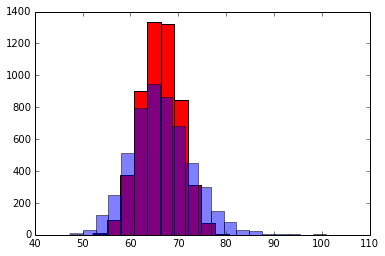

In [43]:
game_dist = np.mean(poss_pred.trace(), axis=0)
plt.hist(game_dist, alpha=1, color='r')
plt.hist(observed_pace, alpha=0.5, bins=20)

In [100]:
pace_rtg.stats().keys()

['95% HPD interval',
 'n',
 'quantiles',
 'standard deviation',
 'mc error',
 'mean']

In [101]:
teams['pace_var'] = pace_rtg.stats()['standard deviation']

['Baylor' 'Iowa' 'Virginia' 'Michigan St.' 'Northwestern' 'Indiana'
 'Nebraska' 'Penn St.' 'Wisconsin' 'Minnesota']



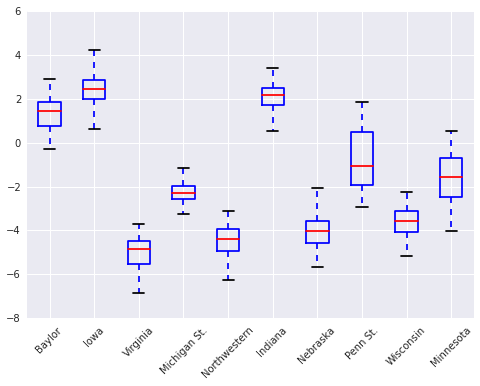

In [117]:
fig, ax = plt.subplots(1, 1)
trace = pace_rtg.trace()
df = pd.DataFrame(trace)
df.head()
data_to_plot = df.iloc[:, :10].values
tms = teams.ncaa[:10].values
print tms
ax.boxplot(data_to_plot)
ax.set_xticklabels(tms, rotation=45)
print